In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [5]:
basetable = Table.read("../catalogs/photometry_tables_merged.ecsv")

In [6]:
bad_shapes = (basetable['sharpness_f410m'] > 0.65) | (basetable['sharpness_f410m'] < 0.50)

In [7]:
not_extended = (~basetable['is_extended_f410m'] & ~basetable['is_extended_f405n-f444w'] & ~basetable['is_extended_f444w-f466n'])

In [8]:
import regions
from astropy.io import fits

In [9]:
fh = fits.open('../images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits')

In [10]:
reg, = regions.Regions.read('../regions/cluster_square.reg')

In [11]:
ww = WCS(fh[1].header)

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(0, 0.5, 'F410m')

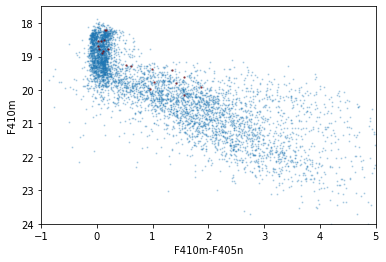

In [12]:
in_cl = reg.contains(basetable['sky_centroid_f410m'], wcs=ww)

pl.scatter((basetable['aper30_abmag_f410m']-basetable['aper30_abmag_f405n-f444w'])[not_extended & ~bad_shapes],
            basetable['aper30_abmag_f410m'][not_extended & ~bad_shapes], 
          s=1, alpha=0.25)
pl.scatter((basetable['aper30_abmag_f410m']-basetable['aper30_abmag_f405n-f444w'])[not_extended & ~bad_shapes & in_cl],
           basetable['aper30_abmag_f410m'][not_extended & ~bad_shapes & in_cl], 
          s=2, alpha=0.5, c='maroon')
#pl.scatter((basetable['aper30_abmag_f444w']-basetable['aper30_abmag_f335m'])[in_r0],
#           basetable['aper30_abmag_f444w'][in_r0], 
#          s=2, alpha=0.9)
#pl.scatter((basetable['aper30_abmag_f444w']-basetable['aper30_abmag_f335m'])[in_r1],
#           basetable['aper30_abmag_f444w'][in_r1], 
#          s=2, alpha=0.9, c='k')

pl.axis([-1,5,24,17.5])
pl.xlabel("F410m-F405n")
pl.ylabel("F410m")

In [13]:
preg = reg.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(fh[1].data)
errcutout = mask.cutout(fh[2].data)
weight = mask.cutout(fh[('WHT', 1)].data)
cutout_slcs,_ = mask.get_overlap_slices(fh[1].data.shape)

In [14]:
cutout_slcs

(slice(1429, 1709, None), slice(3124, 3370, None))

In [15]:
slcs,_ = mask.bbox.get_overlap_slices(fh[1].data.shape)

In [16]:
from astropy.visualization import simple_norm

In [17]:
crds = basetable['sky_centroid_f410m']

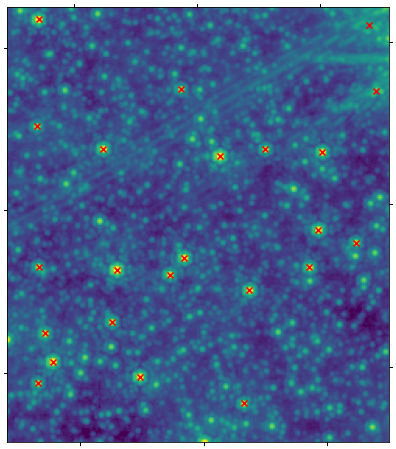

In [18]:
pl.figure(figsize=(8,8))
ax = pl.subplot(projection=ww[slcs])
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log', min_percent=0.1, max_percent=99.9))
pl.scatter(crds.ra[in_cl], crds.dec[in_cl], color='r', marker='x', transform=ax.get_transform('world'))

In [19]:
from astroquery.svo_fps import SvoFps

In [20]:
im1 = fh
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']
wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')

In [21]:
from astropy import units as u

In [22]:
filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
filter_table.add_index('filterID')
instrument = 'NIRCam'
eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filt}']['WavelengthEff'] * u.AA

## Calculate the FWHM for DAOStarFinder

In [23]:
fwhm = (1.22 * eff_wavelength / (6.5*u.m)).to(u.arcsec, u.dimensionless_angles())
fwhm

<Quantity 0.15765703 arcsec>

In [24]:
ww = ww410 = wcs.WCS(im1[1].header)
pixscale = ww.proj_plane_pixel_area()**0.5
fwhm_pix = (fwhm / pixscale).decompose().value
fwhm_pix

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.502493635253329

In [25]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [26]:
import numpy as np

In [27]:
obsdate = im1[0].header['DATE-OBS']

In [28]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F410M'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16

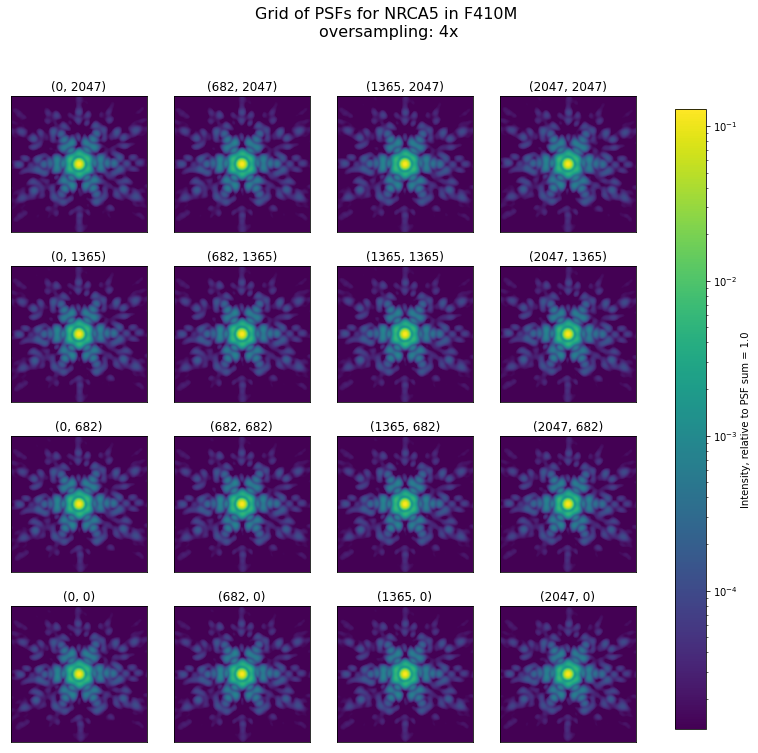

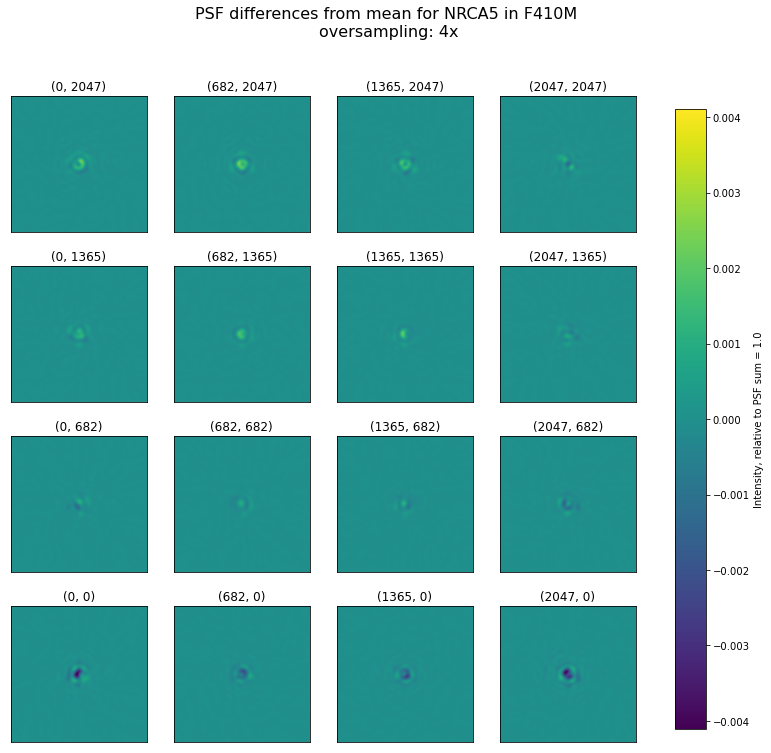

In [29]:
webbpsf.gridded_library.display_psf_grid(grid)

In [30]:
daogroup = DAOGroup(2 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.mad_std(cutout, ignore_nan=True)
print(filtered_errest)

daofind_fin = DAOStarFinder(threshold=50 * filtered_errest, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)
finstars = daofind_fin(cutout)
print(len(finstars))

grid.x_0 = 0
grid.y_0 = 0
def evaluate(x, y, flux, x_0, y_0):
    """
    Evaluate the `GriddedPSFModel` for the input parameters.
    """
    # Get the local PSF at the (x_0,y_0)
    psfmodel = grid._compute_local_model(x_0+slcs[1].start, y_0+slcs[0].start)

    # now evaluate the PSF at the (x_0, y_0) subpixel position on
    # the input (x, y) values
    return psfmodel.evaluate(x, y, flux, x_0, y_0)
grid.evaluate = evaluate

phot = BasicPSFPhotometry(finder=daofind_fin,#finder_maker(),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=(11, 11),
                          aperture_radius=5*fwhm_pix)

phot_ = IterativelySubtractedPSFPhotometry(finder=daofind_fin, group_maker=daogroup,
                                          bkg_estimator=mmm_bkg,
                                          psf_model=grid,
                                          fitter=LevMarLSQFitter(),
                                          niters=2, fitshape=(11, 11), aperture_radius=2*fwhm_pix)

1.071082316186803
44


In [31]:
result = phot(cutout)
len(result)

44

In [32]:
result[:5]

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
126.46159229300088,0.2071103728590226,3839.9209347222322,1,1,126.53202376430137,-0.5845919167287398,4285.946027355207,231.88833566125274,0.03156937162130738,0.06594600807391657
234.25912663507629,9.108581877726929,2786.409228945285,2,2,234.24913402810876,9.114774286034004,978.0231879119672,28.46369079719769,0.03732638282719463,0.038138886148473744
169.70569872982375,9.672266062310273,3070.9434206238275,3,3,169.71877088570852,9.696731281472442,904.0397993239808,27.7082654500429,0.03930873613779318,0.040158378425438485
130.6362244506752,13.457688098887266,3968.0291096937626,4,4,130.6639425053032,13.523748697300054,839.1229617886094,27.908695839404324,0.04265857046073773,0.04357439347505034
151.7405369909789,24.20692599615407,4630.570859642997,5,5,151.7525158197798,24.208850948024732,2106.6768346646413,43.227140297879686,0.026316335865350694,0.026886204368506646


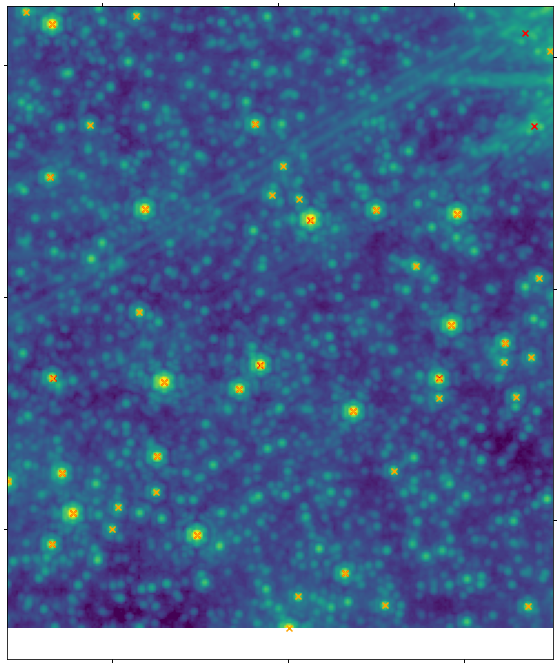

In [33]:
pl.figure(figsize=(12,12))
ax = pl.subplot(projection=ww[slcs])
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log', min_percent=0.1, max_percent=99.9))
pl.scatter(crds.ra[in_cl], crds.dec[in_cl], color='r', marker='x', transform=ax.get_transform('world'))
pl.scatter(result['x_fit'], result['y_fit'], color='orange', marker='x')

In [34]:
resid = phot.get_residual_image()

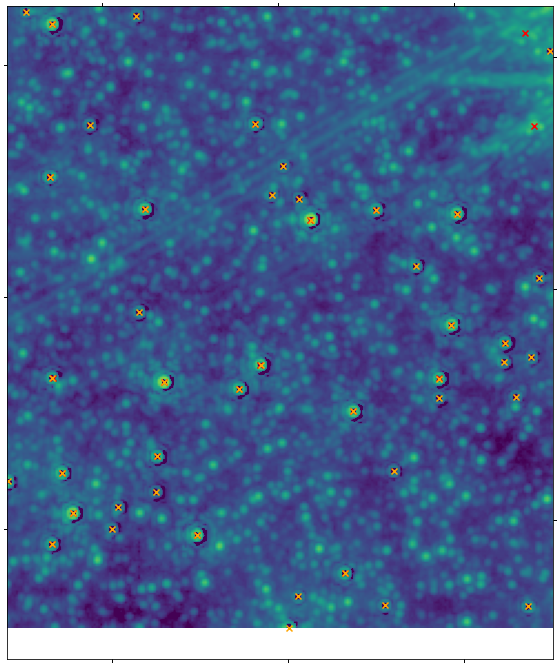

In [35]:
pl.figure(figsize=(12,12))
ax = pl.subplot(projection=ww[slcs])
pl.imshow(resid, norm=simple_norm(cutout, stretch='log', min_percent=0.1, max_percent=99.9))
pl.scatter(crds.ra[in_cl], crds.dec[in_cl], color='r', marker='x', transform=ax.get_transform('world'))
pl.scatter(result['x_fit'], result['y_fit'], color='orange', marker='x')

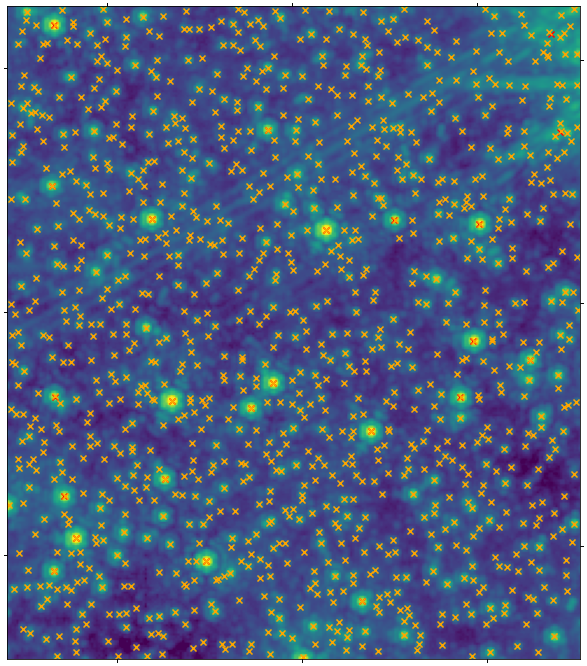

In [36]:
pl.figure(figsize=(12,12))
ax = pl.subplot(projection=ww[slcs])
pl.imshow(cutout, norm=simple_norm(cutout, stretch='log', min_percent=0.1, max_percent=99.9))
pl.scatter(crds.ra[in_cl], crds.dec[in_cl], color='r', marker='x', transform=ax.get_transform('world'))
#pl.scatter(result['x_fit'], result['y_fit'], color='orange', marker='x')
daofind_fin = DAOStarFinder(threshold=1.0, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)
finstars = daofind_fin(cutout)
pl.scatter(finstars['xcentroid'], finstars['ycentroid'], color='orange', marker='x')

# Try crowdsource

In [37]:
import crowdsource
from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

In [38]:
preg.center

PixCoord(x=3246.38354820076, y=1568.8619181706363)

In [39]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F410M'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (68

In [40]:
yy, xx = np.indices([61,61], dtype=float)
grid.x_0 = grid.y_0 = 30
gpsf_at_center = grid(xx, yy)
psf_model = crowdsource.psf.SimplePSF(stamp=gpsf_at_center)

In [41]:
yy, xx = np.indices([61,61], dtype=float)
grid.x_0 = preg.center.x+30
grid.y_0 = preg.center.y+30
gpsf2 = grid(xx+preg.center.x, yy+preg.center.y)
psf_model = crowdsource.psf.SimplePSF(stamp=gpsf2)

In [42]:
from astropy.convolution import convolve, Gaussian2DKernel

In [43]:
gpsf3 = convolve(gpsf2, Gaussian2DKernel(0.55))
psf_model_blur = crowdsource.psf.SimplePSF(stamp=gpsf3)

Text(0.5, 1.0, 'gpsf2-gpsf1')

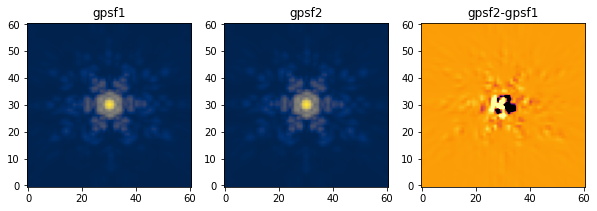

In [44]:
pl.figure(figsize=(10,5))
pl.subplot(1,3,1).imshow(gpsf_at_center, norm=simple_norm(gpsf_at_center, stretch='log'), cmap='cividis')
pl.title("gpsf1")
pl.subplot(1,3,2).imshow(gpsf2, norm=simple_norm(gpsf2, stretch='log'), cmap='cividis')
pl.title("gpsf2")
pl.subplot(1,3,3).imshow(gpsf2-gpsf_at_center, norm=simple_norm(gpsf2-gpsf_at_center, stretch='asinh', min_percent=0.5, max_percent=99.5), cmap='inferno')
pl.title("gpsf2-gpsf1")

Text(0.5, 1.0, 'gpsf2-gpsf1')

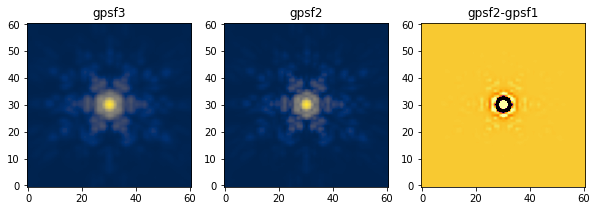

In [45]:
pl.figure(figsize=(10,5))
pl.subplot(1,3,1).imshow(gpsf3, norm=simple_norm(gpsf3, stretch='log'), cmap='cividis')
pl.title("gpsf3")
pl.subplot(1,3,2).imshow(gpsf2, norm=simple_norm(gpsf2, stretch='log'), cmap='cividis')
pl.title("gpsf2")
pl.subplot(1,3,3).imshow(gpsf2-gpsf3, norm=simple_norm(gpsf2-gpsf3, stretch='asinh', min_percent=0.5, max_percent=99.5), cmap='inferno')
pl.title("gpsf2-gpsf1")

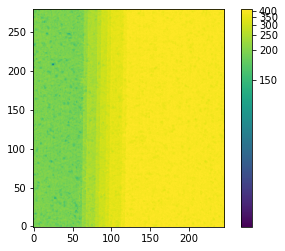

In [46]:
pl.imshow(weight, norm=simple_norm(weight, max_percent=95, stretch='log'))
pl.colorbar()

In [47]:
results  = fit_im(cutout, psf_model, weight=weight,
                                #psfderiv=np.gradient(-psf_initial[0].data),
                                nskyx=1, nskyy=1, refit_psf=True, verbose=True)
stars, modsky, skymsky, psf = results
# shift to account for the cutout, remembering that crowdsource uses inverted x,y axes
stars['y'] += cutout_slcs[1].start
stars['x'] += cutout_slcs[0].start

Extension None, iteration  1, found    982 sources;    0 close and  198 faint sources removed.
Extension None, iteration  2, found    376 sources;    8 close and  112 faint sources removed.
Extension None, iteration  3, found    866 sources;   21 close and   57 faint sources removed.
Extension None, iteration  4, found    790 sources;   35 close and   77 faint sources removed.
Extension None, iteration  5, found    455 sources;   27 close and   56 faint sources removed.
Extension None, iteration  6, found    267 sources;   25 close and   47 faint sources removed.
Extension None, iteration  7, found    180 sources;   15 close and   42 faint sources removed.
Extension None, iteration  8, found    129 sources;   20 close and   48 faint sources removed.
Extension None, iteration  9, found     99 sources;   16 close and   34 faint sources removed.


Text(0.5, 1.0, 'Fitted model')

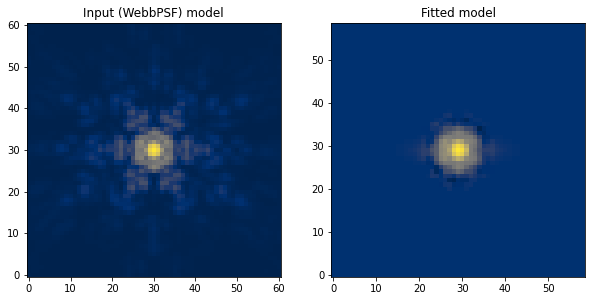

In [48]:
stars, modsky, skymsky, psf = results
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input (WebbPSF) model")
pl.subplot(1,2,2).imshow(psf(30,30), norm=simple_norm(psf(30,30), stretch='log'), cmap='cividis')
pl.title("Fitted model")

Text(0.5, 1.0, 'Blur model')

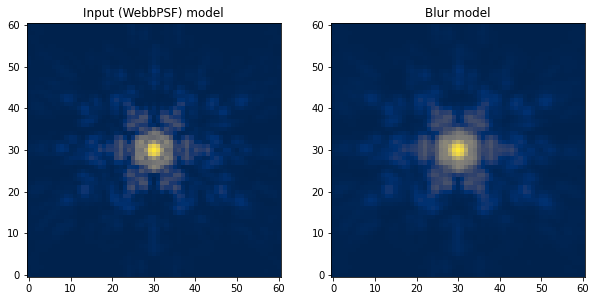

In [49]:
stars, modsky, skymsky, psf = results
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input (WebbPSF) model")
pl.subplot(1,2,2).imshow(psf_model_blur(30,30), norm=simple_norm(psf_model_blur(30,30), stretch='log'), cmap='cividis')
pl.title("Blur model")

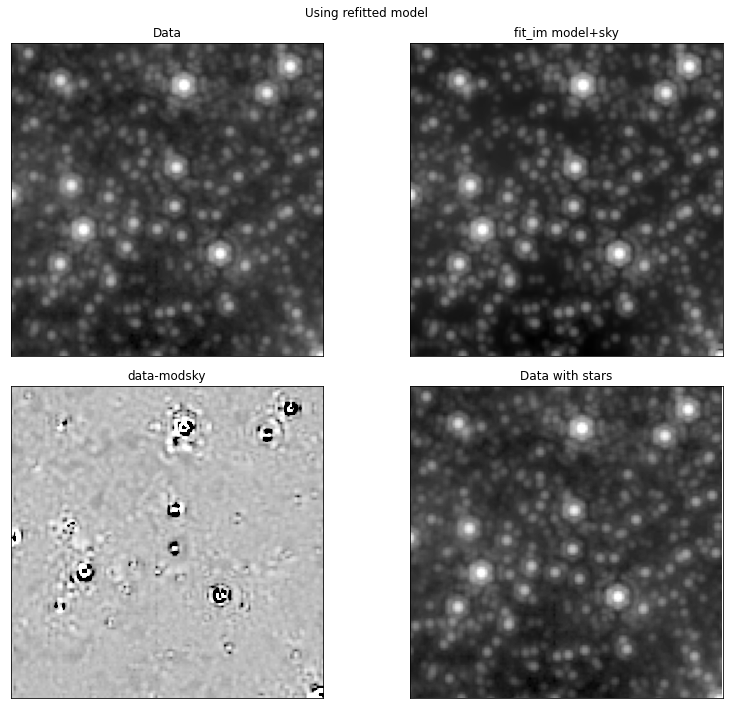

In [50]:
stars, modsky, skymsky, psf = results
pl.figure(figsize=(12,10))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using refitted model")
pl.tight_layout()

In [51]:
results_norefit  = fit_im(cutout, psf_model, weight=weight,
                                #psfderiv=np.gradient(-psf_initial[0].data),
                                nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_norefit
# shift to account for the cutout, remembering that crowdsource uses inverted x,y axes
stars['y'] += cutout_slcs[1].start
stars['x'] += cutout_slcs[0].start

Extension None, iteration  1, found    982 sources;    0 close and  198 faint sources removed.
Extension None, iteration  2, found    353 sources;    4 close and  226 faint sources removed.
Extension None, iteration  3, found   1118 sources;   18 close and   67 faint sources removed.
Extension None, iteration  4, found    977 sources;   56 close and   79 faint sources removed.
Extension None, iteration  5, found    559 sources;   58 close and   68 faint sources removed.
Extension None, iteration  6, found    289 sources;   66 close and   41 faint sources removed.
Extension None, iteration  7, found    196 sources;   52 close and   41 faint sources removed.
Extension None, iteration  8, found    131 sources;   47 close and   42 faint sources removed.
Extension None, iteration  9, found    135 sources;   41 close and   35 faint sources removed.
Extension None, iteration 10, found    106 sources;   36 close and   33 faint sources removed.


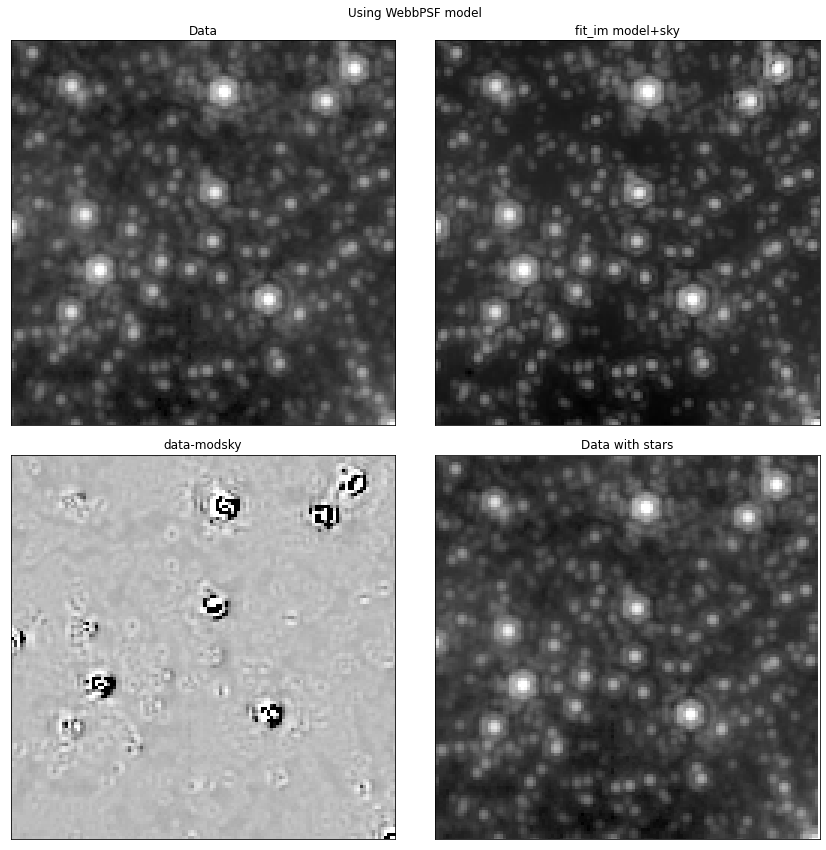

In [52]:
stars, modsky, skymsky, psf = results_norefit
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model")
pl.tight_layout()

In [53]:
results_blur  = fit_im(cutout, psf_model_blur, weight=weight,
                                #psfderiv=np.gradient(-psf_initial[0].data),
                                nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_blur
# shift to account for the cutout, remembering that crowdsource uses inverted x,y axes
stars['y'] += cutout_slcs[1].start
stars['x'] += cutout_slcs[0].start

Extension None, iteration  1, found    856 sources;    0 close and   89 faint sources removed.
Extension None, iteration  2, found    193 sources;    2 close and  106 faint sources removed.
Extension None, iteration  3, found    921 sources;   17 close and   32 faint sources removed.
Extension None, iteration  4, found    586 sources;   24 close and   51 faint sources removed.
Extension None, iteration  5, found    261 sources;   15 close and   23 faint sources removed.
Extension None, iteration  6, found    118 sources;    6 close and   22 faint sources removed.
Extension None, iteration  7, found     56 sources;    7 close and   21 faint sources removed.


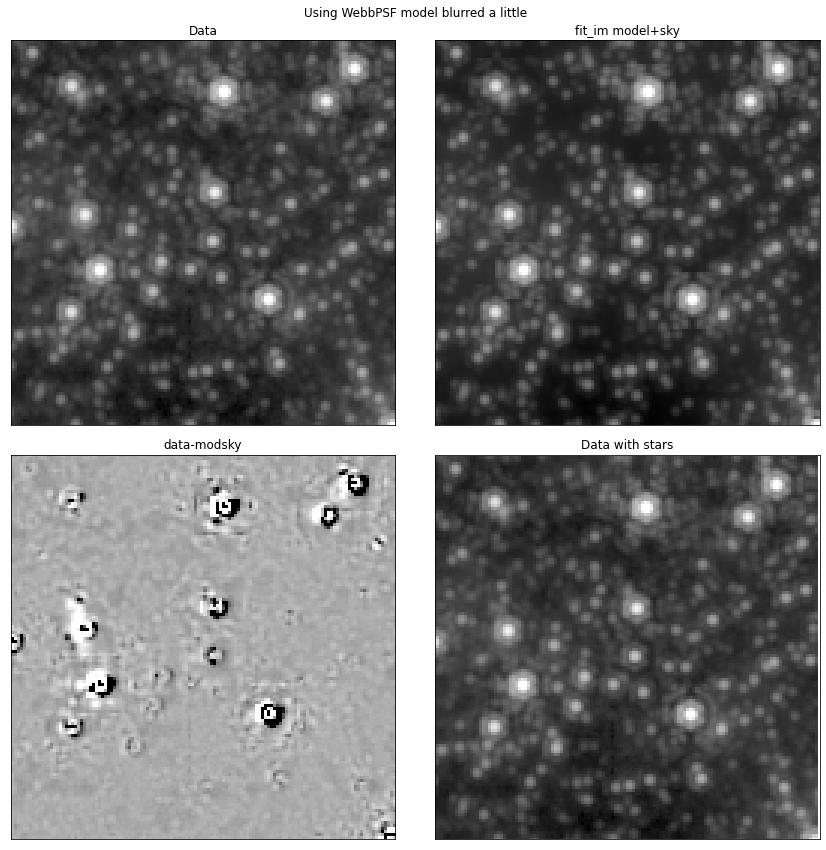

In [54]:
stars, modsky, skymsky, psf = results_blur
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model blurred a little")
pl.tight_layout()

Text(0.5, 1.0, 'Blur model')

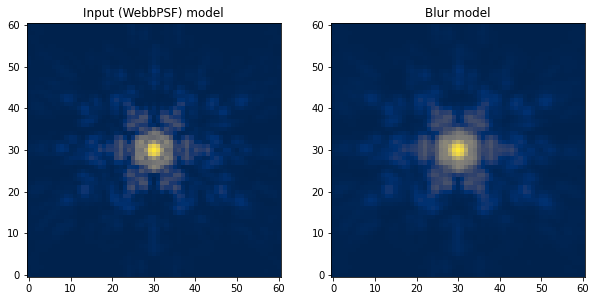

In [55]:
stars, modsky, skymsky, psf = results
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input (WebbPSF) model")
pl.subplot(1,2,2).imshow(psf_model_blur(30,30), norm=simple_norm(psf_model_blur(30,30), stretch='log'), cmap='cividis')
pl.title("Blur model")

In [56]:
stars, modsky, skymsky, psf = results_blur
fits.BinTableHDU(data=stars).writeto("f410_cutout_crowdsource.fits", overwrite=True)

In [57]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F405N'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F405N
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (68

In [58]:
yy, xx = np.indices([61,61], dtype=float)
grid.x_0 = preg.center.x+30
grid.y_0 = preg.center.y+30
gpsf2 = grid(xx+preg.center.x, yy+preg.center.y)
psf_model = crowdsource.psf.SimplePSF(stamp=gpsf2)
gpsf3 = convolve(gpsf2, Gaussian2DKernel(0.55))
psf_model_blur = crowdsource.psf.SimplePSF(stamp=gpsf3)

In [ ]:
fh = fits.open('../images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits')
ww = ww405 = wcs.WCS(fh[1].header)
preg = reg.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(fh[1].data)
errcutout = mask.cutout(fh[2].data)
slcs405 = mask.get_overlap_slices(fh[1].data.shape)
weight = errcutout**-1
weight[errcutout < 1e-5] = 0
weight[errcutout == 0] = np.nanmedian(weight)
weight.max()
weight[weight > np.percentile(weight[np.isfinite(weight)], 99)] = np.percentile(weight[np.isfinite(weight)], 99)
weight[weight < np.percentile(weight[np.isfinite(weight)], 1)] = np.percentile(weight[np.isfinite(weight)], 1)
#weight = mask.cutout(fh[('WHT',1)].data)

Set DATE-AVG to '2022-08-28T00:59:05.370' from MJD-AVG.
Set DATE-END to '2022-08-28T01:27:10.957' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.722509 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527124813.495 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/scratch/local/47745774/ipykernel_57097/2950180139.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  weight = errcutout**-1


In [ ]:
pl.imshow(weight, norm=simple_norm(weight, stretch='log')); pl.colorbar();

In [ ]:
results_blur  = fit_im(cutout, psf_model_blur, weight=weight,
                       nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_blur
# shift to account for the cutout, remembering that crowdsource uses inverted x,y axes
stars['y'] += slcs405[1].start
stars['x'] += slcs405[0].start
fits.BinTableHDU(data=stars).writeto("f405_cutout_crowdsource.fits", overwrite=True)

In [ ]:
stars, modsky, skymsky, psf = results_blur
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model blurred a little")
pl.tight_layout()

In [ ]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F466N'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)

In [ ]:
yy, xx = np.indices([61,61], dtype=float)
grid.x_0 = preg.center.x+30
grid.y_0 = preg.center.y+30
gpsf2 = grid(xx+preg.center.x, yy+preg.center.y)
psf_model = crowdsource.psf.SimplePSF(stamp=gpsf2)
gpsf3 = convolve(gpsf2, Gaussian2DKernel(0.55))
psf_model_blur = crowdsource.psf.SimplePSF(stamp=gpsf3)

In [ ]:
fh = fits.open('../images/jw02221-o001_t001_nircam_f444w-f466n_i2d.fits')
ww = ww466 = wcs.WCS(fh[1].header)
preg = reg.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(fh[1].data)
errcutout = mask.cutout(fh[2].data)
slcs466 = mask.get_overlap_slices(fh[1].data.shape)
weight = errcutout**-1
weight[errcutout < 1e-5] = 0
weight[errcutout == 0] = np.nanmedian(weight)
weight.max()
weight[weight > np.percentile(weight[np.isfinite(weight)], 99)] = np.percentile(weight[np.isfinite(weight)], 99)
weight[weight < np.percentile(weight[np.isfinite(weight)], 1)] = np.percentile(weight[np.isfinite(weight)], 1)

In [ ]:
pl.imshow(weight, norm=simple_norm(weight, stretch='log')); pl.colorbar();

In [ ]:
results_blur  = fit_im(cutout, psf_model_blur, weight=weight,
                       nskyx=1, nskyy=1, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results_blur
# shift to account for the cutout, remembering that crowdsource uses inverted x,y axes
stars['y'] += slcs_466[1].start
stars['x'] += slcs_466[0].start
fits.BinTableHDU(data=stars).writeto("f466_cutout_crowdsource.fits", overwrite=True)

In [ ]:
stars, modsky, skymsky, psf = results_blur
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model blurred a little")
pl.tight_layout()

In [ ]:
cat410 = Table.read('f410_cutout_crowdsource.fits')
cat405 = Table.read('f405_cutout_crowdsource.fits')
cat466 = Table.read('f466_cutout_crowdsource.fits')

In [ ]:
cat410[:5]

In [ ]:
import scipy.spatial

In [ ]:
ls ../images/jw02221*i2d.fits

In [ ]:
basetable = cat410 = Table.read('f410_cutout_crowdsource.fits')
basecrds = np.array([cat410['x'], cat410['y']]).T
basetree = scipy.spatial.KDTree(basecrds)
baseww = wcs.WCS(fits.getheader('../images/jw02221-o001_t001_nircam_clear-f410m_i2d.fits', ext=('SCI', 1)))
baseskycrds = baseww.pixel_to_world(cat410['y'], cat410['x'])
basetable.add_column(baseskycrds, name='skycoords')
basetable.meta['filter'] = 'f410'
for colname in basetable.colnames:
    basetable.rename_column(colname, colname+"_f410")
#basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

cat405 = Table.read('f405_cutout_crowdsource.fits')
cat466 = Table.read('f466_cutout_crowdsource.fits')
for tbl, name, fn in ((cat405, 'f405', '../images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits'),
                      (cat466, 'f466', '../images/jw02221-o001_t001_nircam_f444w-f466n_i2d.fits')):
    wl = name
#    tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
    crds = np.array([tbl['x'], tbl['y']]).T
    
    if os.path.exists(fn.replace(".fits", "_correctedWCS.hdr")):
        ww = wcs.WCS(fits.Header.fromtextfile(fn.replace(".fits", "_correctedWCS.hdr")))
    else:
        ww = wcs.WCS(fits.getheader(fn, ext=('SCI', 1)))
    skycrds = ww.pixel_to_world(tbl['y'], tbl['x'])
    tbl.add_column(skycrds, name=f'skycoords')
    tbl.meta['filter'] = name
    
    matches, sep, _ = baseskycrds.match_to_catalog_sky(skycrds, nthneighbor=1)    
    
    #tree = scipy.spatial.KDTree(crds)
    #sep, matches = tree.query(basecrds, k=1)
    #sep_, matches_ = basetree.query(crds, k=1)
    closest = np.array([ss == np.min(sep[matches==mm]) for ss,mm in zip(sep, matches)], dtype='bool')
    basetable.add_column(name=f"sep_{wl}", col=sep)
    basetable.add_column(name=f"id_{wl}", col=matches)
    basetable.add_column(name=f"match_{wl}", col=closest)
    matchtb = tbl[matches]
    for cn in matchtb.colnames:
        #matchtb[cn][sep > 0.1*u.arcsec].mask = True
        matchtb.rename_column(cn, f"{cn}_{wl}")
    basetable = table.hstack([basetable, matchtb], join_type='exact')
    #if 'sky_centroid_f444w' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
    #basetable = table.join(basetable, tbl,
    #                      table_names=['', wl],
    #                      join_type='outer',
    #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
    #if 'sky_centroid_' in basetable.colnames:
    #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
    basetable.write("crowdsource_f410_f405_f466_photometry_tables_merged.fits", overwrite=True)

In [ ]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410']
ii = 1
for tbl in [cat405,cat410,cat466]:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(f"median offset: {np.median(radiff)} {np.median(decdiff)}")
    ax.grid()
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

# Correct some headers

In [ ]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [ ]:
ww = wcs.WCS(fits.getheader(f'{basepath}/images/jw02221-o001_t001_nircam_f405n-f444w_i2d.fits', ext=('SCI', 1)))
ww.wcs.crval[0] = ww.wcs.crval[0] - 0.160  / 3600.
ww.wcs.crval[1] = ww.wcs.crval[1] - 0.0808 / 3600.
ww.to_header().totextfile(f'{basepath}/images/jw02221-o001_t001_nircam_f405n-f444w_i2d_correctedWCS.hdr', overwrite=True)

In [ ]:
ww = wcs.WCS(fits.getheader(f'{basepath}/images/jw02221-o001_t001_nircam_f444w-f466n_i2d.fits', ext=('SCI', 1)))
ww.wcs.crval[0] = ww.wcs.crval[0] - 0.16139 / 3600. 
ww.wcs.crval[1] = ww.wcs.crval[1] - 0.083 / 3600.
ww.to_header().totextfile(f'{basepath}/images/jw02221-o001_t001_nircam_f444w-f466n_i2d_correctedWCS.hdr', overwrite=True)

In [ ]:
pl.hist(basetable['sep_f405'] )

In [ ]:
pl.hist(basetable['sep_f466'] )

In [ ]:
smallsep = (basetable['sep_f405'] < 6) & (basetable['sep_f466'] < 6)
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((cutout-modsky)[:128,:128], norm=simple_norm((cutout-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.subplot(2,2,4).scatter(basetable['y_f410'][smallsep], basetable['x_f410'][smallsep], marker='x', color='lime', s=8, linewidth=0.5)
pl.subplot(2,2,4).scatter(basetable['y_f466'][smallsep], basetable['x_f466'][smallsep], marker='x', color='yellow', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");
pl.suptitle("Using WebbPSF model blurred a little")
pl.tight_layout()

In [ ]:
sel = smallsep = (basetable['sep_f405'] < 0.1) & (basetable['sep_f466'] < 0.1) & (basetable['match_f405']) & (basetable['match_f466'])
pl.scatter(basetable['flux_f410'], basetable['flux_f405'])
pl.scatter(basetable['flux_f410'][sel], basetable['flux_f405'][sel])

In [ ]:
pl.figure(figsize=(10,10))
pl.imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.scatter(basetable['y_f410'][smallsep], basetable['x_f410'][smallsep], marker='x', color='lime', s=8, linewidth=0.5)
pl.scatter(basetable['y_f466'][smallsep], basetable['x_f466'][smallsep], marker='x', color='yellow', s=8, linewidth=0.5)
pl.axis([0,128,0,128])

In [ ]:
ww410[slcs].world_to_pixel(basetable['skycoords_f410'])[0].max()

In [ ]:
pl.figure(figsize=(10,10))
slcs,_ = mask.get_overlap_slices(fh[1].data.shape)
ax = pl.subplot(projection=ww410[slcs][:128,:128])
ax.imshow(cutout[:128,:128], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
ax.scatter(basetable['skycoords_f405'][smallsep].ra, basetable['skycoords_f405'][smallsep].dec, transform=ax.get_transform('world'), marker='x', color='r', s=8, linewidth=0.5)
ax.scatter(basetable['skycoords_f410'][smallsep].ra, basetable['skycoords_f410'][smallsep].dec, transform=ax.get_transform('world'), marker='x', color='lime', s=8, linewidth=0.5)
ax.scatter(basetable['skycoords_f466'][smallsep].ra, basetable['skycoords_f466'][smallsep].dec, transform=ax.get_transform('world'), marker='x', color='yellow', s=8, linewidth=0.5)
pl.axis([0,128,0,128])

In [ ]:
#pl.scatter(basetable['flux_f410m']/basetable['flux_f405'], basetable['flux_f405'], s=10)
pl.scatter((basetable['flux_f410m']/basetable['flux_f405'])[sel], basetable['flux_f405'][sel], alpha=0.5, s=10)
pl.loglog();

In [ ]:
#pl.scatter(basetable['flux_f410m']/basetable['flux_f466'], basetable['flux_f466'], s=10)
pl.scatter((basetable['flux_f410m']/basetable['flux_f466'])[sel], basetable['flux_f466'][sel], alpha=0.5, s=10)
pl.loglog();

In [ ]:
#pl.scatter(basetable['flux_f405']/basetable['flux_f466'], basetable['flux_f466'], s=10)
pl.scatter((basetable['flux_f405']/basetable['flux_f466'])[sel], basetable['flux_f466'][sel], alpha=0.5, s=10)
pl.loglog();

In [ ]:
bright = basetable['flux_f405'] > 150

pl.scatter((basetable['flux_f405']/basetable['flux_f410m'])[sel], (basetable['flux_f466']/basetable['flux_f410m'])[sel], alpha=0.5, s=10)
pl.scatter((basetable['flux_f405']/basetable['flux_f410m'])[sel & bright], (basetable['flux_f466']/basetable['flux_f410m'])[sel & bright], alpha=0.5, s=10)
pl.xlabel("F405 / F410")
pl.ylabel("F466 / F410")
pl.loglog();

In [ ]:
ha_excess = basetable['flux_f405'] / basetable['flux_f410m'] > 1.5
co_excess = basetable['flux_f466'] / basetable['flux_f410m'] > 2
co_deficit = basetable['flux_f466'] / basetable['flux_f410m'] < 0.5

In [ ]:
pl.figure(figsize=(10,10))
pl.imshow(cutout[:,:], norm=simple_norm(cutout[:256,:256], stretch='log', max_percent=99.95), cmap='gray')
pl.scatter(basetable['y_f410m'][smallsep & ha_excess & bright], basetable['x_f410m'][smallsep & ha_excess & bright], marker='x', color='red', s=8, linewidth=0.75)
pl.scatter(basetable['y_f410m'][smallsep & co_excess & bright], basetable['x_f410m'][smallsep & co_excess & bright], marker='o', edgecolor='blue', facecolor='none', s=15, linewidth=0.75)
pl.scatter(basetable['y_f410m'][smallsep & co_deficit & bright], basetable['x_f410m'][smallsep & co_deficit & bright], marker='o', edgecolor='yellow', facecolor='none', s=15, linewidth=0.75)

#pl.axis([0,128,0,128])